In [1]:
import pandas as pd
data=pd.read_csv("D:\DDOS.csv")

In [2]:
data[" Label"] = data[" Label"].replace('BENIGN',0)
data[" Label"] = data[" Label"].replace('UDP',1)
data[" Label"] = data[" Label"].replace('Syn',2)
data[" Label"] = data[" Label"].replace('MSSQL',3)
data[" Label"] = data[" Label"].replace('NetBIOS',4)
data[" Label"] = data[" Label"].replace('LDAP',5)
data[" Label"] = data[" Label"].replace('Portmap',6)
datalb=data[" Label"]
data = data.drop([" Label"], axis='columns')


In [3]:
from sklearn.model_selection import train_test_split
train_sents, test_sents, train_labels, test_labels = train_test_split(data.values, datalb.values, test_size=0.2)


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_sents = scaler.fit_transform(train_sents)
train_sents = pd.DataFrame(train_sents)

In [5]:
test_sents = scaler.fit_transform(test_sents)
test_sents = pd.DataFrame(test_sents)

In [6]:
import numpy as np
train_sents=np.array(train_sents)
test_sents=np.array(test_sents)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([   
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=7))
 ])
poly_kernel_svm_clf.fit(train_sents, train_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=7, coef0=1, kernel='poly'))])

In [8]:
from sklearn.metrics import accuracy_score
y_pre = poly_kernel_svm_clf.predict(test_sents)
print('Training size = %d, accuracy = %.2f%%' % \
      (train_sents.shape[0],accuracy_score(test_labels, y_pre)*100))

Training size = 392000, accuracy = 77.04%


In [7]:
from sklearn.linear_model import LogisticRegression
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=7)
softmax_reg.fit(train_sents, train_labels)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=7, multi_class='multinomial')

In [8]:
from sklearn.metrics import accuracy_score
y_pre = softmax_reg.predict(test_sents)
print('Training size = %d, accuracy = %.2f%%' % \
      (train_sents.shape[0],accuracy_score(test_labels, y_pre)*100))

Training size = 392000, accuracy = 82.73%


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
  DecisionTreeClassifier(max_depth=3), n_estimators=7,
  algorithm="SAMME.R", learning_rate=0.01
)
ada_clf.fit(train_sents, train_labels)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.01, n_estimators=7)

In [10]:
from sklearn.metrics import accuracy_score
y_pre =ada_clf.predict(test_sents)
print('Training size = %d, accuracy = %.2f%%' % \
      (train_sents.shape[0],accuracy_score(test_labels, y_pre)*100))

Training size = 392000, accuracy = 84.53%


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [16]:
def LSTM_model(input_size):

    # Initialize the constructor
    model = Sequential()

    model.add(LSTM(32,input_shape=(input_size,1), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(7, activation='softmax'))  # Update units and activation function
    print(model.summary())
    return model

In [22]:
def compile_train(model,X_train,y_train,deep=True, epochs=10):

    if(deep==True):
        import matplotlib.pyplot as plt

        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        history = model.fit(X_train, y_train,epochs=epochs, batch_size=512, verbose=1)

        plt.plot(history.history['accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()

        print(model.metrics_names)

    else:
        model.fit(X_train, y_train) #SVM, LR, GD

    print('Model Compiled and Trained')
    return model

In [8]:
def save_model(model,name):
    from keras.models import model_from_json

    arq_json = 'Models' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)

    arq_h5 = 'Models' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')

def load_model(name):
    from keras.models import model_from_json

    arq_json = 'Models' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    arq_h5 = 'Models' + name + '.h5'
    loaded_model.load_weights(arq_h5)

    print('Model loaded')

    return loaded_model

In [19]:
from keras.models import Sequential

from keras.layers import Dense,Embedding,Dropout,Flatten,MaxPooling1D,LSTM

In [7]:
def format_3d(df):
    
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
 dense_5 (Dense)             (None, 7)                 77        
                                                                 
Total params: 4759 (18.59 KB)
Trainable params: 4759 (18.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
766/766 [==============================] - 38s 47ms/step - loss: 1.3299 - accuracy: 0.4557
Epoch 2/10
766/766 [=========================

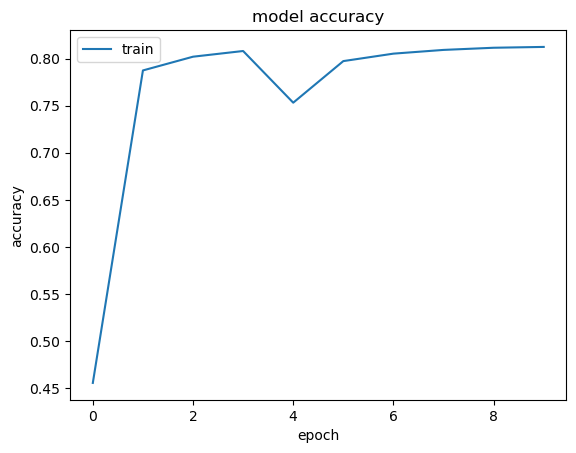

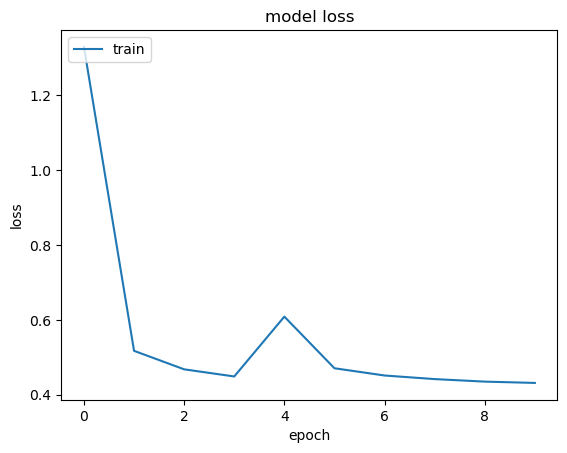

['loss', 'accuracy']
Model Compiled and Trained


In [34]:
from tensorflow.keras.models import Sequential
model_lstm2 = LSTM_model(73)
model_lstm2 = compile_train(model_lstm2,format_3d(train_sents.astype(np.float32)),train_labels.astype(np.float32), epochs=25)

In [43]:
save_model(model_lstm2,"lstm")

Model Saved


In [9]:
lstm=load_model("lstm")



Model loaded


In [10]:
lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
from sklearn.metrics import accuracy_score
y_pred = lstm.predict(format_3d(test_sents)) 
y_pred = np.argmax(y_pred, axis=1)
print('Training size = %d, accuracy = %.2f%%' % \
      (train_sents.shape[0],accuracy_score(test_labels, y_pred)*100))
from sklearn.metrics import precision_recall_fscore_support
print(str(precision_recall_fscore_support(test_labels, y_pred, average='macro')))
print(str(precision_recall_fscore_support(test_labels, y_pred, average='micro')))

3063/3063 [==============================] - 16s 5ms/step
Training size = 392000, accuracy = 82.59%
(0.7539281039675659, 0.7473521861582119, 0.733444005529359, None)
(0.8258775510204082, 0.8258775510204082, 0.8258775510204082, None)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import joblib

joblib.dump(ada_clf, "adaboost.pkl") 

In [13]:
svm=joblib.load("adaboost.pkl")

In [14]:
from sklearn.metrics import accuracy_score
y_pre = svm.predict(test_sents)
print('Training size = %d, accuracy = %.2f%%' % \
      (train_sents.shape[0],accuracy_score(test_labels, y_pre)*100))
from sklearn.metrics import precision_recall_fscore_support
print(str(precision_recall_fscore_support(test_labels, y_pre, average='macro')))
print(str(precision_recall_fscore_support(test_labels, y_pre, average='micro')))

Training size = 392000, accuracy = 84.89%
(0.7663792042466274, 0.8346540432441414, 0.7957547733639069, None)
(0.8489387755102041, 0.8489387755102041, 0.8489387755102041, None)


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
import joblib

joblib.dump(softmax_reg, "softmax.pkl") 

['softmax.pkl']

In [15]:
sm=joblib.load("softmax.pkl")

In [16]:
from sklearn.metrics import accuracy_score
y_pred = sm.predict(test_sents)
print('Training size = %d, accuracy = %.2f%%' % \
      (train_sents.shape[0],accuracy_score(test_labels, y_pred)*100))
from sklearn.metrics import precision_recall_fscore_support
print(str(precision_recall_fscore_support(test_labels, y_pred, average='macro')))
print(str(precision_recall_fscore_support(test_labels, y_pred, average='micro')))

Training size = 392000, accuracy = 82.46%
(0.7858367521002231, 0.8147354144619425, 0.7755637803821933, None)
(0.8245510204081633, 0.8245510204081633, 0.8245510204081633, None)


In [14]:
import joblib

joblib.dump(poly_kernel_svm_clf, "poly_kernel_svm_clf.pkl") 

['poly_kernel_svm_clf.pkl']

In [17]:
poly_kernel_svm_clf=joblib.load("poly_kernel_svm_clf.pkl")

In [18]:
from sklearn.metrics import accuracy_score
y_pred = poly_kernel_svm_clf.predict(test_sents)
print('Training size = %d, accuracy = %.2f%%' % \
      (train_sents.shape[0],accuracy_score(test_labels, y_pred)*100))
from sklearn.metrics import precision_recall_fscore_support
print(str(precision_recall_fscore_support(test_labels, y_pred, average='macro')))
print(str(precision_recall_fscore_support(test_labels, y_pred, average='micro')))

Training size = 392000, accuracy = 81.94%
(0.8608901363732594, 0.8053461839329525, 0.7781032207028283, None)
(0.8194285714285714, 0.8194285714285714, 0.8194285714285714, None)
